# SynCom_MLR_Models


# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Data

In [2]:
path = '/home/rdmtinez/Desktop/MScThesis/data_o/calibration/community_calibration/parsed_data/'
fname = 'community_calibration_dataframe.csv'

mdf = pd.read_csv(pjoin(path,fname), sep=',', index_col='well')

######################################
# correct values used for regression #
######################################
for col in [i for i in mdf.columns[4:].values if 'sdv' not in i]:
    #subtract 'blank' well values
    mdf.loc[:,col] = mdf.loc[:,col] - mdf.loc['H12',col]

In [3]:
mdf.head()

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,660,670,680,690,700,710,720,730,740,750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,1.2798,1.4125,1.4652,1.2293,0.9723,0.8896,0.8541,0.8298,0.8166,0.8032
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,1.2044,1.3205,1.3658,1.1698,0.9243,0.8486,0.8149,0.7924,0.7793,0.7660
A3,A,3,0.4,0.42,0.9685,0.0768,1.2995,0.0818,0.7890,0.0758,...,1.1188,1.2301,1.2734,1.0813,0.8680,0.7985,0.7672,0.7458,0.7334,0.7209
A4,A,4,0.4,0.38,0.9106,0.0732,1.2021,0.0791,0.7450,0.0742,...,1.0456,1.1440,1.1832,1.0131,0.8222,0.7584,0.7300,0.7094,0.6977,0.6858
A5,A,5,0.4,0.34,0.8852,0.0785,1.1458,0.0879,0.7252,0.0804,...,0.9979,1.0872,1.1227,0.9692,0.7939,0.7354,0.7079,0.6883,0.6763,0.6646


# Helper Function

In [26]:
def plot_pred_vs_known(mdf, column='440', ml_model=False, set_B_C=True):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()
    
    if set_B_C:
        df = set_B_and_C(df, column)
    
    
    fs = (8, 10)
    
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    print(Bp)
    smx = max(df[Bp].max(), df['B'].max())
    smx = smx+.1*smx
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8), ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx) 
    axes[0].set_ylim(bottom=-0.01, top=smx)



    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12), ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':9})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

    # get predicted values from column named
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Cp].max(), df['C'].max())
    smx = smx+.1*smx
    
    
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8), ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]_{pred}}$')
    axes[0].set_xlabel('$[C]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.01, right=smx)
    axes[0].set_ylim(bottom=-0.01, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12), ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':9}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]_{pred}}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.01, right=smx)
    axes[1].set_ylim(bottom=-0.01, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("[Chlamy] Predictions Using Simple Linear Regression Models @"+column, y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()
    
    
    
def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        df.loc[(df['row']==row) & (df['col']==12), column]
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        df.loc[df['col']==col, 'C'] = value
    
    return df


def MLR_fitter(dframe, regressands= ['A680', '720'], regressor='560', set_B_C=True, metrics=False):
    """This function returns the fitters from a multiple linear regression that
    regress back to [B] and [C], i.e. the returned fitters allow you to make predictions
    """
    
    df=dframe.copy()
    
    X = df[regressands]
    
    if set_B_C:

        yB = set_B_and_C(df,regressor)[['B']]
        yC = set_B_and_C(df,regressor)[['C']]
    
    else:
        yB = df.loc[:,'B']
        yC = df.loc[:,'C']

    XtrnB, XtstB, ytrnB, ytstB = train_test_split(X, yB, test_size=0.20, random_state=7)
    XtrnC, XtstC, ytrnC, ytstC = train_test_split(X, yC, test_size=0.20, random_state=7)

    rB = LinearRegression().fit(XtrnB, ytrnB)
    rC = LinearRegression().fit(XtrnC, ytrnC)
    
    if metrics==True:
        """If metrics true it returns the test variables to check the fits"""
        return rB, rC, XtstB, ytstB, XtstC, ytstC
    
    return rB, rC


def get_MLR_predictions(dframe, regressands=['A680', '720'], regressor='560', regressors_B_C=None, set_B_C=True):
    """Returns the complete predictions for the regresor as series for i in range(2):
    which can be appended to an existing dataframe. If regressors are passed it ingores
    the regressands and regressor and only returns the predicitons using
    those regressors"""
    
    if regressors_B_C==None:
        """If regressors haven't been created previously with MLR_fitter(), then this
        function first calls that function to assess the predictions over the regressor series"""
        
        regressors_B_C = MLR_fitter(dframe, regressands=regressands,
                                    regressor=regressor, set_B_C=set_B_C)
        
    df = dframe.copy()
    
    df['B_pML_'+regressor] = regressors_B_C[0].predict(df[regressands])
    df['C_pML_'+regressor] = regressors_B_C[1].predict(df[regressands])
    
    return df[['B_pML_'+regressor ,'C_pML_'+regressor]]
    

def get_model_metrics(dframe, regressands=['A680', '720'],regressor='560',regressors_B_C=None):
    
    df = dframe.copy()
    
    if regressors_B_C==None:
        """This prints out goodness-of-fit for any regressor and regressor for the
        MODELS and TEST DATA only and returns the models as well so that you
        can use them to make the predictions.
        """
        rB, rC, XtstB, ytstB, XtstC, ytstC = MLR_fitter(df, regressands,
                                                  regressor, metrics=True)
        
        
        ypB = rB.predict(XtstB)
        ypC = rC.predict(XtstC)
        
        print('Bp_'+regressor+'_MSE', mse(ytstB, ypB))
        print('Bp_'+regressor+'_R^2', r2s(ytstB, ypB))
        
        print('Cp_'+regressor+'_MSE', mse(ytstC, ypC))
        print('Cp_'+regressor+'_R^2', r2s(ytstC, ypC))
        
        return rB, rC
    
    elif regressors_B_C:
        
        """This prints out the good-of-fit values for all of the predictions against
        the actual regressor values, to double-check these values run the rB rC predictors
        on the entirity of the [regressors] wavelength"""
        
        df = set_B_and_C(dframe, regressor)
        
        ypB = regressors_B_C[0].predict(df[regressands])
        ypC = regressors_B_C[1].predict(df[regressands])       
        
        print('Bp_'+regressor+'_MSE', mse(df[['B']], ypB))
        print('Bp_'+regressor+'_R^2',r2s(df[['B']], ypB))
        
        print('Cp_'+regressor+'_MSE',mse(df[['C']], ypC))
        print('Cp_'+regressor+'_R^2',r2s(df[['C']], ypC))


def get_model_coefficients(dframe, regressands, regressor):
    
    rB, rC = MLR_fitter(dframe, regressands, regressor=regressor)
    
    return rB.coef_[0][0], rB.coef_[0][1], rC.coef_[0][0], rC.coef_[0][1]


def get_coeff_dict_for_all_regressors_ML(df, regressands=['A680', 'A720']):
    """
    This function calls the get_regression_coefficient function and builds models which regress back
    to ALL the regressor wavelength 500 to 750. Pay careful attention to which regressands were used.
    Ensure to name your dictionary accordingly, lest you forget what your models are using.
    """
    
    
    regressors = ['A600', '500', '510', '520',
              '530', '540', '550', '560',
              '570', '580', '590', '600',
              '610', '620', '630', '640',
              '650', '660', '670', '680',
              '690', '700', '710', '720',
               '730', '740', '750']
    
    # stores the coefficients which regress back to each regressor
    coefficients = {}
    
    for regr in regressors:
        coefficients[regr] = get_model_coefficients(df, regressands, regr)
                
    return coefficients


# New Model Parameter Learning

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score as r2s
import statsmodels.api as sm

In [6]:
#

In [7]:
lambdas = [i for i in mdf.columns.values[6:] if 'sdv' not in i][3:]

tdf = mdf.copy()
for wave in lambdas:
    tdf = pd.merge(tdf, get_MLR_predictions(tdf, regressands=['A680', 'A720'],
                                          regressor=wave), left_index=True, right_index=True, )

In [8]:
# save_to = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/calibration/community_calibration/predicted_fractions"""
# tdf.to_csv(pjoin(save_to, 'a680_a720_ml_pred_fractions.csv'))

In [9]:
lambdas = [i for i in mdf.columns.values[6:] if 'sdv' not in i][3:]

tdf = mdf.copy()
for wave in lambdas:
    tdf = pd.merge(tdf, get_MLR_predictions(tdf, regressands=['A680', 'A750'],
                                          regressor=wave), left_index=True, right_index=True, )

In [10]:
# save_to = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/calibration/community_calibration/predicted_fractions"""
# tdf.to_csv(pjoin(save_to, 'a680_a750_ml_pred_fractions.csv'))

In [11]:
lambdas = [i for i in mdf.columns.values[6:] if 'sdv' not in i][3:]

tdf = mdf.copy()
for wave in lambdas:
    tdf = pd.merge(tdf, get_MLR_predictions(tdf, regressands=['A680', '730'],
                                          regressor=wave), left_index=True, right_index=True, )

In [12]:
# save_to = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/calibration/community_calibration/predicted_fractions"""
# tdf.to_csv(pjoin(save_to, 'a680_730_ml_pred_fractions.csv'))

# Get & Save All Model Coefficients

In [13]:
a680_a720_ml = get_coeff_dict_for_all_regressors_ML(mdf, regressands= ['A680', 'A720'])
a680_730_ml = get_coeff_dict_for_all_regressors_ML(mdf, regressands= ['A680', '730'])
a680_a750_ml = get_coeff_dict_for_all_regressors_ML(mdf, regressands= ['A680', 'A750'])
                                                    


In [58]:
save_to = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/\
            data_o/calibration/community_calibration/created_models"""
tdf = pd.DataFrame.from_dict(data=a680_a720_ml,
                             orient='index',
                             columns=['kB680m', 'kB720m', 'kC680m', 'kC720m'])
#tdf.to_csv(pjoin(save_to,'a680_a720_ml_coefficients.csv'))
tdf.head()

tdf = pd.DataFrame.from_dict(data=a680_730_ml,
                             orient='index',
                             columns=['kB680m', 'kB730m', 'kC680m', 'kC730m'])
#tdf.to_csv(pjoin(save_to,'a680_730_ml_coefficients.csv'))
tdf.head()

tdf = pd.DataFrame.from_dict(data=a680_a750_ml,
                             orient='index',
                             columns=['kB680m', 'kB750m', 'kC680m', 'kC750m'])
#tdf.to_csv(pjoin(save_to,'a680_a750_ml_coefficients.csv'))
tdf.head()

,kB680m,kB720m,kC680m,kC720m
A600,-1.397520,2.975766,1.359733,-1.496666
500,-1.661957,3.538012,2.214690,-2.452154
510,-1.625643,3.461147,1.927548,-2.131637
520,-1.593268,3.392390,1.654851,-1.828232
530,-1.562181,3.326458,1.502302,-1.658930


,kB680m,kB730m,kC680m,kC730m
A600,-1.449364,3.047585,1.386647,-1.534414
500,-1.724864,3.625858,2.242803,-2.483005
510,-1.686963,3.546658,1.953503,-2.161398
520,-1.653399,3.476259,1.678210,-1.855886
530,-1.621039,3.408495,1.523757,-1.684525


,kB680m,kB750m,kC680m,kC750m
A600,-1.347691,3.034884,1.332707,-1.522341
500,-1.601900,3.606618,2.170015,-2.493405
510,-1.566935,3.528356,1.888656,-2.167382
520,-1.535753,3.458320,1.621708,-1.859329
530,-1.505821,3.391183,1.472220,-1.687130


# Build Combined Data ML Models

In [27]:
path = '/home/rdmtinez/Desktop/MScThesis/data_o/calibration/single_species_calibration/parsed_data'
fname = 'single_strain_calibration_dataframe.csv'

ocdf = pd.read_csv(pjoin(path,fname), sep=',', index_col='well')

######################################
# correct values used for regression #
######################################
for col in [i for i in ocdf.columns[4:].values]:
    #subtract 'blank' well values
    ocdf.loc[:,col] = ocdf.loc[:,col] - ocdf.loc['H12',col]

ocdf= ocdf.rename({'720':'A720'}, axis=1)


# since we would like to use 720 signal to create our new models we rename
# just this column so that it maches the A720 signal from the new syncom cal. data
# thus avoid NAs
path = '/home/rdmtinez/Desktop/MScThesis/data_o/calibration/community_calibration/parsed_data'
fname = 'community_calibration_dataframe.csv'

ccdf = pd.read_csv(pjoin(path,fname), sep=',', index_col='well')
######################################
# correct values used for regression #
######################################
for col in [i for i in ccdf.columns[4:].values]:
    #subtract 'blank' well values
    ccdf.loc[:,col] = ccdf.loc[:,col] - ccdf.loc['H12',col]

cdfs = [ocdf, ccdf]

stdf = pd.concat(cdfs, sort=False).reset_index(drop=True).dropna(axis=1, how='any')
lambdas = [i for i in stdf.columns.values[7:]]


for wave in lambdas:
    for i in range(2):
        cdfs[i] = set_B_and_C(cdfs[i], column=wave)
    tdf = pd.concat(cdfs, sort=False).reset_index(drop=True).dropna(axis=1, how='any')
    
    stdf = pd.merge(stdf, get_MLR_predictions(tdf, regressands=['A680', 'A720'],
                    set_B_C=False, regressor=wave), left_index=True, right_index=True)    

B_pML_560


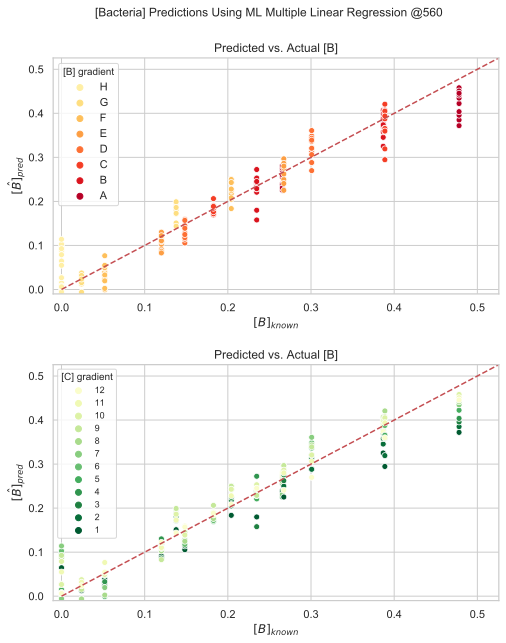

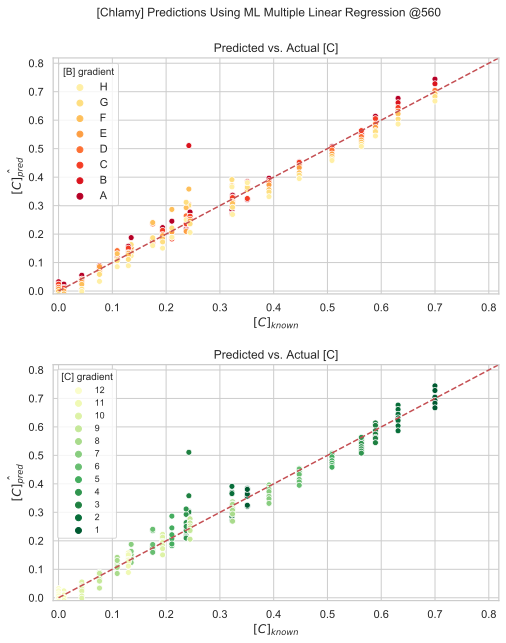

In [35]:

VIS_COL = '560'

for i in range(2):
    cdfs[i] = set_B_and_C(cdfs[i], column=VIS_COL)

temp = pd.concat(cdfs, sort=False).reset_index(drop=True).dropna(axis=1, how='any')

stdf['B'] = temp['B']
stdf['C'] = temp['C']

plot_pred_vs_known(stdf, column=VIS_COL, ml_model=True, set_B_C=False)

# New Models Against Old Calib Data

In [36]:
# Load old data and use the new model to predict the old measurements
# compare against the the sum of the predicted values against the measured 560 values
# after predicting old values with new model create the cell count models


In [78]:
def ml_coefficients_to_predictions(df, coef_df, regressor='560', regressands=['A680', 'A750']):
    
    tdf = df.copy()

    kB6, kB7, kC6, kC7 = coef_df.loc[regressor]
    
    
    tdf['B_pML_'+regressor] = kB6*tdf[regressands[0]] + kB7*tdf[regressands[1]]
    tdf['C_pML_'+regressor] = kC6*tdf[regressands[0]] + kC7*tdf[regressands[1]]
    
    return tdf[['B_pML_'+regressor ,'C_pML_'+regressor]]

In [70]:
ocdf.head()


,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.4148,0.4122,0.4095,0.4067,0.4043,0.4019,0.3995,0.3977,0.3955,0.3937
B1,B,1,0.175,0.25,4832,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.4158,0.4129,0.4099,0.4070,0.4041,0.4014,0.3989,0.3967,0.3943,0.3923
C1,C,1,0.150,0.25,4638,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.3793,0.3768,0.3741,0.3710,0.3688,0.3665,0.3642,0.3622,0.3600,0.3582
D1,D,1,0.125,0.25,4775,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.3473,0.3447,0.3418,0.3389,0.3366,0.3342,0.3319,0.3299,0.3277,0.3258
E1,E,1,0.100,0.25,4936,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.3319,0.3293,0.3266,0.3236,0.3214,0.3191,0.3168,0.3146,0.3124,0.3105


In [71]:
path = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/\
calibration/community_calibration/created_models"""

a680_a720_ml = pd.read_csv(pjoin(path,'a680_a720_ml_coefficients.csv'), index_col=0)
a680_730_ml = pd.read_csv(pjoin(path,'a680_730_ml_coefficients.csv'), index_col=0)
a680_a750_ml = pd.read_csv(pjoin(path,'a680_a750_ml_coefficients.csv'), index_col=0)


In [83]:
lambdas = [i for i in a680_a720.index.values]
lambdas

['A600',
 '500',
 '510',
 '520',
 '530',
 '540',
 '550',
 '560',
 '570',
 '580',
 '590',
 '600',
 '610',
 '620',
 '630',
 '640',
 '650',
 '660',
 '670',
 '680',
 '690',
 '700',
 '710',
 '720',
 '730',
 '740',
 '750']

In [86]:
tdf = ocdf.copy()
for wave in lambdas:
    tdf = pd.merge(tdf, ml_coefficients_to_predictions(tdf, a680_a750_ml, regressor=wave, 
                    regressands=['A680', 'A750']), left_index=True, right_index=True, )


In [88]:
tdf.columns.values

array(['row', 'col', 'B_lbl', 'C_lbl', 'F680', 'A680', 'A750', '320',
       '325', '330', '335', '340', '345', '350', '355', '360', '365',
       '370', '375', '380', '385', '390', '395', '400', '405', '410',
       '415', '420', '425', '430', '435', '440', '445', '450', '455',
       '460', '465', '470', '475', '480', '485', '490', '495', '500',
       '505', '510', '515', '520', '525', '530', '535', '540', '545',
       '550', '555', '560', '565', '570', '575', '580', '585', '590',
       '595', '600', '605', '610', '615', '620', '625', '630', '635',
       '640', '645', '650', '655', '660', '665', '670', '675', '680',
       '685', '690', '695', '700', '705', '710', '715', 'A720', '725',
       '730', '735', '740', '745', '750', '755', '760', '765', '770',
       '775', '780', '785', '790', '795', '800', 'B_pML_A600',
       'C_pML_A600', 'B_pML_500', 'C_pML_500', 'B_pML_510', 'C_pML_510',
       'B_pML_520', 'C_pML_520', 'B_pML_530', 'C_pML_530', 'B_pML_540',
       'C_pML_540', '

In [89]:
plot_pred_vs_known(tdf, column='600', ml_model=True)



# Here we're saying that the 560 OLD measurements are truth, but we know that the data
# collected by the tecan was fairly shitty

# Absorance to Cell Counts